In [1]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec

sns.set_context(rc = {'legend.fontsize': 8, 'ytick.labelsize': 8, 'xtick.labelsize':8, 'axes.labelsize':8})
matplotlib.rcParams["font.family"] = "Arial"

OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'
tss_df = pd.read_csv(f'{OUT_DIR}/tss_df.csv').query('dataset == "optimized"')

# coverage of operons w/ and w/o TSS

In [2]:
bv1_df = gffpd.read_gff3('../../01-INPUT/04-REFERENCE/BV1-C58.gff').df.sort_values(['seq_id','start','end'])

cds_df = bv1_df.query('type != "gene"').copy()
cds_df = cds_df[cds_df['attributes'].apply(lambda x: 'ID' in x)]
cds_df['attributes'] = cds_df['attributes'].apply(lambda x: {y.split('=')[0]:y.split('=')[1] for y in x.split(';')})
cds_df['cds_ID'] = cds_df['attributes'].apply(lambda x: x['ID'])
cds_df = cds_df.drop(columns=['attributes','score','phase','source','type'])

gene_df = bv1_df.query('type == "gene"').copy()
gene_df['attributes'] = gene_df['attributes'].apply(lambda x: {y.split('=')[0]:y.split('=')[1] for y in x.split(';')})
gene_df['gene_ID'] = gene_df['attributes'].apply(lambda x: x['Name'])
gene_df = gene_df.drop(columns=['attributes','score','phase','source','type'])

atu_df = pd.read_csv('../../01-INPUT/04-REFERENCE/BV1-C58_mod.gff',sep='\t')[['seq_id','start','end','strand','ID']]
bv1_df = atu_df.merge(cds_df,on=['seq_id','start','end','strand']).merge(gene_df,on=['seq_id','start','end','strand'])
cds_atu = dict(zip(bv1_df['cds_ID'],bv1_df['ID']))
gene_atu = dict(zip(bv1_df['gene_ID'],bv1_df['ID']))
bv1_df.to_csv(f'{OUT_DIR}/bv1_annotations.csv',index=False)

bv1_df

,seq_id,start,end,strand,ID,cds_ID,gene_ID
0,NC_003062.2,203,1024,+,Atu0001,cds-WP_010970590.1,ATU_RS00005
1,NC_003062.2,1056,1655,+,Atu0002,cds-WP_010970591.1,actR
2,NC_003062.2,1648,2508,+,Atu0003,cds-WP_010970592.1,ATU_RS00015
3,NC_003062.2,2508,3089,+,Atu0004,cds-WP_010970593.1,ATU_RS00020
4,NC_003062.2,3110,3808,+,Atu0005,cds-WP_010970594.1,dnaQ
...,...,...,...,...,...,...,...
5141,NC_003065.3,206051,206242,+,Atu6189,cds-WP_010891482.1,ATU_RS23895
5142,NC_003065.3,206256,207926,+,Atu6190,cds-WP_010974922.1,ATU_RS23900
5143,NC_003065.3,207993,210047,+,Atu6191,cds-WP_010974923.1,ATU_RS23905
5144,NC_003065.3,211215,211946,-,Atu6193,cds-WP_010974924.1,ATU_RS23930


In [3]:
bv1_df['type'] = 'gene'
bv1_df = bv1_df.sort_values(['seq_id','start','end','strand']).drop(columns=['cds_ID','gene_ID'])
bv1_df['biovar'] = 'BV1'

bv2_df = gffpd.read_gff3('../../01-INPUT/04-REFERENCE/BV2-C16_80.gff').df
bv2_df = bv2_df.query('type == "gene"')
bv2_df['attributes'] = bv2_df['attributes'].apply(lambda x: {y.split('=')[0]:y.split('=')[1] for y in x.split(';')})
bv2_df['ID'] = bv2_df['attributes'].apply(lambda x: x['ID'])
bv2_df = bv2_df.drop(columns=['attributes','score','phase','source'])
bv2_df['biovar'] = 'BV2'

bv3_df = gffpd.read_gff3('../../01-INPUT/04-REFERENCE/BV3-T60_94.gff').df
bv3_df = bv3_df.query('type == "gene"')
bv3_df['attributes'] = bv3_df['attributes'].apply(lambda x: {y.split('=')[0]:y.split('=')[1] for y in x.split(';')})
bv3_df['ID'] = bv3_df['attributes'].apply(lambda x: x['ID'])
bv3_df = bv3_df.drop(columns=['attributes','score','phase','source'])
bv3_df['biovar'] = 'BV3'

gff_df = pd.concat([ bv1_df, bv2_df, bv3_df]).reset_index(drop=True)
gff_df.to_csv(f'{OUT_DIR}/all_gff_df.csv',index=False)
ID_contig_map = dict(zip(gff_df['ID'],gff_df['seq_id']))
gff_df


,seq_id,start,end,strand,ID,type,biovar
0,NC_003062.2,203,1024,+,Atu0001,gene,BV1
1,NC_003062.2,1056,1655,+,Atu0002,gene,BV1
2,NC_003062.2,1648,2508,+,Atu0003,gene,BV1
3,NC_003062.2,2508,3089,+,Atu0004,gene,BV1
4,NC_003062.2,3110,3808,+,Atu0005,gene,BV1
...,...,...,...,...,...,...,...
17816,pTi,152755,155223,-,FLNPIO_28400,gene,BV3
17817,pTi,155234,155533,-,FLNPIO_28405,gene,BV3
17818,pTi,155526,155933,-,FLNPIO_28410,gene,BV3
17819,pTi,155923,156894,-,FLNPIO_28415,gene,BV3


In [5]:
def parse_operons(in_file):
    operon_df = pd.read_csv(in_file,sep='\t')
    operon_count = 0
    operon_dict = {}
    for idx,row in operon_df.iterrows():
        if not pd.isnull(row['Operon']):
            operon_count = int( row['Operon'] )
        if not pd.isnull(row['Type']): # find first gene in operon
            genes = []
            if operon_count not in operon_dict: # instantiate operon
                curr_start = int( row['PosLeft'] )
                curr_end = int( row['postRight'] )
                curr_strand = row['Strand']
                if type(row['IdGene']) == float: # gene has no id
                    curr_gene = 'NaN'
                else:
                    curr_gene = row['IdGene']
                genes.append(curr_gene)
                operon_dict[operon_count] = (curr_start, curr_end, curr_strand, genes, 1)
            else: # update operon 
                operon_start, operon_end, operon_strand, genes, operon_genes = operon_dict[operon_count]
                genes.append(row['IdGene'])
                curr_end = int( row['postRight'] )
                operon_dict[operon_count] = (operon_start, curr_end, operon_strand, genes, operon_genes + 1)

    out_df = pd.DataFrame.from_dict(operon_dict,orient='index',columns=['start', 'end', 'strand', 'genes', 'gene_count'])
    return out_df

bv1_df = parse_operons('../../01-INPUT/04-REFERENCE/BV1-operons.txt')
bv1_df['operon_id'] = range(1,len(bv1_df) + 1)
bv1_df = bv1_df[~bv1_df['operon_id'].isin(range(2672,2786))]
bv1_df['biovar'] = 'BV1'

bv2_df = parse_operons('../../01-INPUT/04-REFERENCE/BV2-operons.txt')
bv2_df['operon_id'] = range(1,len(bv2_df) + 1)
bv2_df['biovar'] = 'BV2'

bv3_df = parse_operons('../../01-INPUT/04-REFERENCE/BV3-operons.txt')
bv3_df['operon_id'] = range(1,len(bv3_df) + 1)
bv3_df['biovar'] = 'BV3'

operon_df = pd.concat([ bv1_df, bv2_df, bv3_df])
operon_df.to_csv(f'{OUT_DIR}/operon_df.csv',index=False)

def get_leader(gene_list, strand):
    if strand == '+':
        return gene_list[0]
    elif strand == '-':
        return gene_list[-1]
    else:
        raise Exception('error!')

operon_df = operon_df.explode('genes')
operon_df = operon_df.rename(columns={'genes':'ID'})#.drop(columns=['duplicate_operon'])
operon_df['ID'] = operon_df['ID'].apply(lambda x: x.replace('.p01',''))
operon_df['ID'] = operon_df['ID'].replace(cds_atu).replace(gene_atu)
operon_df = operon_df.drop_duplicates(subset=['start', 'end', 'strand', 'ID', 'gene_count', 'biovar'])
operon_df.to_csv(f'{OUT_DIR}/operon_df_melted.csv')
operon_df

,start,end,strand,ID,gene_count,operon_id,biovar
1,203,3808,+,Atu0001,5,1,BV1
1,203,3808,+,Atu0002,5,1,BV1
1,203,3808,+,Atu0003,5,1,BV1
1,203,3808,+,Atu0004,5,1,BV1
1,203,3808,+,Atu0005,5,1,BV1
...,...,...,...,...,...,...,...
3114,304855,315002,-,FLNPIO_27645,12,3114,BV3
3114,304855,315002,-,FLNPIO_27650,12,3114,BV3
3114,304855,315002,-,FLNPIO_27655,12,3114,BV3
3114,304855,315002,-,FLNPIO_27660,12,3114,BV3


,biovar,start,end,strand,gene_count,operon_id,ID
1,BV1,203,3808,+,5,1,"[Atu0001, Atu0002, Atu0003, Atu0004, Atu0005]"
10,BV1,3907,4389,-,1,2,[Atu0006]
12,BV1,4493,5029,-,1,3,[Atu0007]
14,BV1,5170,7905,+,4,4,"[Atu0008, Atu0009, Atu0010, Atu0011]"
20,BV1,8064,10499,+,1,5,[Atu0012]
...,...,...,...,...,...,...,...
10330,BV3,301485,303050,+,1,3110,[FLNPIO_27585]
10333,BV3,303112,303481,-,2,3111,"[FLNPIO_27590, FLNPIO_27595]"
10335,BV3,303554,303877,+,1,3112,[FLNPIO_27600]
10336,BV3,303880,304620,-,1,3113,[FLNPIO_27605]


In [5]:
merged_df = operon_df.merge(tss_df,left_on=['biovar','ID'],right_on=['biovar','TSS_locus_tag'])

counts = merged_df.groupby(['biovar','contig','operon_id']).agg({'TSS_class': lambda x: x.to_list()}).reset_index()
counts['count'] = counts['TSS_class'].apply(lambda x: len(x))
counts['TSS_class'] = counts['TSS_class'].apply(lambda x: str(x))

coverage_df = operon_df.sort_values(['biovar','operon_id'])[['biovar','operon_id','start','end','strand','gene_count']].merge(counts,on=['biovar','operon_id'],how='outer').drop_duplicates().reset_index(drop=True)
coverage_df['contig'] = coverage_df['contig'].fillna(method='ffill')
coverage_df['count'] = coverage_df['count'].fillna(0).astype(int)
coverage_df['has_TSS'] = coverage_df['count'].apply(lambda x: x > 0)
coverage_df

,biovar,operon_id,start,end,strand,gene_count,contig,TSS_class,count,has_TSS
0,BV1,1,203,3808,+,5,NC_003062.2,['primary'],1,True
1,BV1,2,3907,4389,-,1,NC_003062.2,['primary'],1,True
2,BV1,3,4493,5029,-,1,NC_003062.2,NaN,0,False
3,BV1,4,5170,7905,+,4,NC_003062.2,['primary'],1,True
4,BV1,5,8064,10499,+,1,NC_003062.2,['antisense'],1,True
...,...,...,...,...,...,...,...,...,...,...
12749,BV3,3110,301485,303050,+,1,plasmid2,['primary'],1,True
12750,BV3,3111,303112,303481,-,2,plasmid2,"['antisense', 'primary']",2,True
12751,BV3,3112,303554,303877,+,1,plasmid2,['primary'],1,True
12752,BV3,3113,303880,304620,-,1,plasmid2,['primary'],1,True


In [6]:
bv1 = coverage_df.query('biovar == "BV1"').copy()
# bv1
bv1 = bv1[~bv1['operon_id'].isin(range(2672,2786))]
bv1_ye = bv1[bv1['count'].apply(lambda x: x > 0)]
bv1_no = bv1[bv1['count'].apply(lambda x: x == 0)]

( len(bv1_ye) / len(bv1) ) * 100, ( bv1_ye['gene_count'].sum() / bv1['gene_count'].sum() ) * 100

(48.74779541446208, 56.13142968902797)

In [7]:
bv2 = coverage_df.query('biovar == "BV2"').copy()
bv2_ye = bv2[bv2['count'].apply(lambda x: x > 0)]
bv2_no = bv2[bv2['count'].apply(lambda x: x == 0)]

( len(bv2_ye) / len(bv2) ) * 100, ( bv2_ye['gene_count'].sum() / bv2['gene_count'].sum() ) * 100

(41.68993387215283, 48.5921889191644)

In [8]:
bv3 = coverage_df.query('biovar == "BV3"').copy()
bv3_ye = bv3[bv3['count'].apply(lambda x: x > 0)]
bv3_no = coverage_df.query('biovar == "BV3"').copy()

(len(bv3_ye)/len(bv3)) * 100, ( bv3_ye['gene_count'].sum() / bv3['gene_count'].sum() ) * 100

(53.46820809248555, 58.80063683000177)

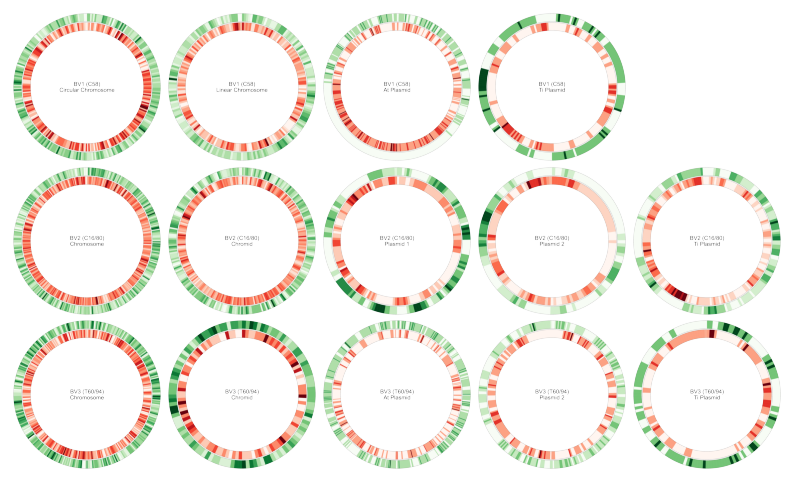

In [9]:
# import pycircos
# line1_map = {'BV1': 'BV1 (C58)','BV2':'BV2 (C16/80)', 'BV3':'BV3 (T60/94)'}
# line2_map = {'chromid':'Chromid', 'chromosome':'Chromosome', 'pAt':'At Plasmid', 'pTi':'Ti Plasmid', 'plasmid1':'Plasmid 1', 'plasmid2':'Plasmid 2', "NC_003062.2":"Circular Chromosome","NC_003063.2":"Linear Chromosome","NC_003064.2":"At Plasmid","NC_003065.3":"Ti Plasmid"}
# for bv in coverage_df['biovar'].unique():
#     for path in glob(f'../../02-OUTPUT/04-TSS/TSS_GBK/{bv}*'):
#         contig = path.split('-')[-1].replace('.gb','')
#         query = coverage_df.query(f"biovar == '{bv}' and contig == '{contig}'")

#         dna = path.split('/')[-1].replace('.gb','')
#         record = SeqIO.read(path,format='genbank')

#         line1, line2 = dna.split('-')
#         line1 = line1_map[line1]
#         line2 = line2_map[line2]

#         if 'plasmid' in line2.lower():
#             window = 1_000
#         else:
#             window = 10_000
        
#         garc = pycircos.Garc(arc_id=dna, record=record, interspace=0, linewidth=0, 
#             facecolor="#FFFFFF00", raxis_range=(0,10), label=f'{line1}\n{line2}', label_visible=True, labelsize=20)
#         gcircle = pycircos.Gcircle()
#         gcircle.add_garc(garc)
#         gcircle.set_garcs()

#         yes_tss  = [] 
#         no_tss = []

#         for idx, row in query.iterrows():
#             if row['has_TSS']:
#                 yes_tss.append((row['start'],row['end']))
#             else:
#                 no_tss.append((row['start'],row['end']))
#         WIDTH = 100
#         MARGIN = 10
#         ranges = [( 900-WIDTH*(i+1)-MARGIN*(i),900-WIDTH*i-MARGIN*(i) ) for i in range(5)]

#         yes_density  = garc.calc_density(yes_tss, window_size=window)
#         gcircle.heatmap(dna, yes_density, raxis_range=ranges[0], cmap=plt.cm.Greens, spine=True)

#         no_density  = garc.calc_density(no_tss, window_size=window)
#         gcircle.heatmap(dna, no_density, raxis_range=ranges[1], cmap=plt.cm.Reds, spine=True)
        
#         plt.savefig(f'{OUT_DIR}/operoncoverage_' + dna +'.png',dpi=300,transparent=True,bbox_inches='tight')

fig, axarr = plt.subplots(3,5,figsize=(10,6))
CROP = 100
axarr[0,0].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003062.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,0].axis('off')
axarr[0,1].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003063.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,1].axis('off')
axarr[0,2].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003064.2.png')[CROP:-CROP,CROP:-CROP])
axarr[0,2].axis('off')
axarr[0,3].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV1-NC_003065.3.png')[CROP:-CROP,CROP:-CROP])
axarr[0,3].axis('off')
axarr[0,4].axis('off')

axarr[1,0].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[1,0].axis('off')
axarr[1,1].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[1,1].axis('off')
axarr[1,2].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-plasmid1.png')[CROP:-CROP,CROP:-CROP])
axarr[1,2].axis('off')
axarr[1,3].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[1,3].axis('off')
axarr[1,4].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV2-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[1,4].axis('off')

axarr[2,0].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-chromosome.png')[CROP:-CROP,CROP:-CROP])
axarr[2,0].axis('off')
axarr[2,1].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-chromid.png')[CROP:-CROP,CROP:-CROP])
axarr[2,1].axis('off')
axarr[2,2].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-pAt.png')[CROP:-CROP,CROP:-CROP])
axarr[2,2].axis('off')
axarr[2,3].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-plasmid2.png')[CROP:-CROP,CROP:-CROP])
axarr[2,3].axis('off')
axarr[2,4].imshow(plt.imread(f'{OUT_DIR}/operoncoverage_BV3-pTi.png')[CROP:-CROP,CROP:-CROP])
axarr[2,4].axis('off')

fig.subplots_adjust(hspace=0,wspace=0)
fig.savefig(f'{OUT_DIR}/operoncoverage.png',dpi=300,transparent=True,bbox_inches='tight')